## Import libraries

In [1]:
!pip install torchmultimodal-nightly

In [2]:
import torch
import torchvision
import torchvision.transforms.functional as F

from torch import nn
from tqdm import tqdm
from torchmultimodal.diffusion_labs.modules.adapters.cfguidance import CFGuidance
from torchmultimodal.diffusion_labs.modules.losses.diffusion_hybrid_loss import DiffusionHybridLoss
from torchmultimodal.diffusion_labs.samplers.ddpm import DDPModule
from torchmultimodal.diffusion_labs.predictors.noise_predictor import NoisePredictor
from torchmultimodal.diffusion_labs.schedules.discrete_gaussian_schedule import linear_beta_schedule, DiscreteGaussianSchedule
from torchmultimodal.diffusion_labs.transforms.diffusion_transform import RandomDiffusionSteps
from torchmultimodal.diffusion_labs.utils.common import DiffusionOutput

## Schedule

In [3]:
# Define Diffusion Schedule

schedule = DiscreteGaussianSchedule(linear_beta_schedule(1000))

## Predictor

In [4]:
# Define Prediction Target

predictor = NoisePredictor(schedule, lambda x: torch.clamp(x, -1, 1))

## U-Net

In [ ]:
# from torchmultimodal.diffusion_labs.models.adm_unet.adm import adm_unet

# unet = adm_unet(
#     time_embed_dim=32,
#     embed_dim=32,
#     embed_name="context",
#     predict_variance_value=True,
#     image_channels=1,
# )

In [5]:
# Down scaling input blocks for unet
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, cond_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels + cond_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.pooling = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x, c):
        _, _, w, h = x.size()
        c = c.expand(-1, -1, w, h)              # Shape conditional input to match image
        x = self.block(torch.cat([x, c], 1))    # Convolutions over image + condition
        x_small = self.pooling(x)               # Downsample output for next block
        return x, x_small

# Upscaling blocks on unet
class UpBlock(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(2*inp, out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out, out, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, x, x_small):
        x_big = self.upsample(x_small)          # Upscale input back towards original size
        x = torch.cat((x_big, x), dim=1)        # Join previous block with accross block
        x = self.block(x)                       # Convolutions over image
        return x

class UNet(nn.Module):
    def __init__(self, time_size=32, digit_size=32, steps=1000):
        # Define UNet
        super().__init__()
        cond_size = time_size + digit_size
        self.conv = nn.Conv2d(1, 128, kernel_size=3, padding=1)
        self.down = nn.ModuleList([DownBlock(128, 256, cond_size), DownBlock(256, 512, cond_size)])
        self.bottleneck = DownBlock(512, 512, cond_size)
        self.up = nn.ModuleList([UpBlock(512, 256), UpBlock(256, 128)])

        self.time_projection = nn.Embedding(steps, time_size)
        self.prediction = nn.Conv2d(128, 1, kernel_size=3, padding=1)
        self.variance = nn.Conv2d(128, 1, kernel_size=3, padding=1)

    def forward(self, x, t, conditional_inputs):
        # Define forward
        b, c, h, w = x.shape
        timestep = self.time_projection(t).view(b, -1, 1, 1)
        condition = conditional_inputs["context"].view(b, -1, 1, 1)
        condition = torch.cat([timestep, condition], dim = 1)

        x = self.conv(x)
        outs = []
        for block in self.down:
            out, x = block(x, condition)
            outs.append(out)
        x, _ = self.bottleneck(x, condition)

        for block in self.up:
            x = block(outs.pop(), x)
        v = self.variance(x)
        p = self.prediction(x)
        return DiffusionOutput(p, v)

## Diffusion Model

In [6]:
unet = UNet(time_size=32, digit_size=32)
unet = CFGuidance(unet, {"context": 32}, guidance=2.0)
# Add support for classifier free guidance

In [7]:
# Define evalution
eval_steps = torch.linspace(0, 999, 250, dtype=torch.long)
model = DDPModule(unet, schedule, predictor, eval_steps)

In [8]:
# Define conditional embeddings
encoder = nn.Embedding(10, 32)

## Data

In [9]:
from torchvision.transforms import Compose, Resize, ToTensor, Lambda

diffusion_transform = RandomDiffusionSteps(schedule, batched=False)
transform = Compose([Resize(32),
                      ToTensor(),
                      Lambda(lambda x: 2*x - 1),
                      Lambda(lambda x: diffusion_transform({"x":x}))])

In [18]:
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

train_dataset = FashionMNIST("fashion_mnist", train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=192, shuffle=True, num_workers=2, pin_memory=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 15779553.36it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270766.28it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4934159.85it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18973881.36it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



## Train

In [23]:
epochs = 25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
model.to(device)

# Apply optimizer to diffusion model and encoder for joint training
optimizer = torch.optim.AdamW(
    [{"params": encoder.parameters()}, {"params": model.parameters()}], lr=0.0001
)
# Define loss
h_loss = DiffusionHybridLoss(schedule)

encoder.train()
model.train()
for e in range(epochs):
	for sample in (pbar := tqdm(train_dataloader)):
		x, c = sample
		x0, xt, noise, t, c = x["x"].to(device), x["xt"].to(device), x["noise"].to(device), x["t"].to(device), c.to(device)
		optimizer.zero_grad()

		# Compute loss
		embedding = encoder(c)
		out = model(xt, t, {"context": embedding})
		loss = h_loss(out.prediction, noise, out.mean, out.log_variance, x0, xt, t)

		loss.backward()
		optimizer.step()

		pbar.set_description(f'{e+1}| Loss: {loss.item()}')

1| Loss: 0.03961247205734253: 100%|██████████| 313/313 [02:30<00:00,  2.08it/s]
2| Loss: 0.03322608023881912: 100%|██████████| 313/313 [02:32<00:00,  2.05it/s]
3| Loss: 0.03857649862766266: 100%|██████████| 313/313 [02:33<00:00,  2.04it/s]
4| Loss: 0.025304025039076805: 100%|██████████| 313/313 [02:32<00:00,  2.05it/s]
5| Loss: 0.024071624502539635: 100%|██████████| 313/313 [02:32<00:00,  2.05it/s]
6| Loss: 0.03112674131989479: 100%|██████████| 313/313 [02:32<00:00,  2.05it/s]
7| Loss: 0.029244132339954376: 100%|██████████| 313/313 [02:32<00:00,  2.05it/s]
8| Loss: 0.02714388072490692: 100%|██████████| 313/313 [02:32<00:00,  2.05it/s]
9| Loss: 0.03297431394457817: 100%|██████████| 313/313 [02:32<00:00,  2.05it/s]
10| Loss: 0.02924567647278309: 100%|██████████| 313/313 [02:32<00:00,  2.05it/s]
11| Loss: 0.032739948481321335: 100%|██████████| 313/313 [02:32<00:00,  2.05it/s]
12| Loss: 0.027462465688586235: 100%|██████████| 313/313 [02:32<00:00,  2.05it/s]
13| Loss: 0.03261525183916092: 1

## Generate

In [24]:
def fashion_encoder(name, num=1):
    fashion_dict = {"t-shirt": 0, "pants": 1, "sweater": 2, "dress": 3, "coat": 4,
                    "sandal": 5, "shirt": 6, "sneaker": 7, "purse": 8, "boot": 9}
    idx = torch.as_tensor([fashion_dict[name] for _ in range(num)]).to(device)

    encoder.eval()
    with torch.no_grad():
        embed = encoder(idx)
    return embed

  0%|          | 0/250 [00:00<?, ?it/s]

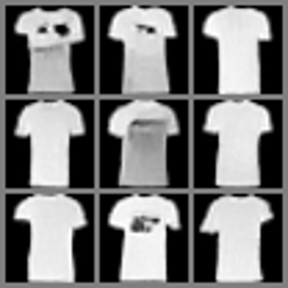

In [31]:
model.eval()

c = fashion_encoder("t-shirt", 9)
noise = torch.randn(size=(9,1,32,32)).to(device)

with torch.no_grad():
    imgs = model(noise, conditional_inputs={"context": c})

img_grid = torchvision.utils.make_grid(imgs, 3)
img = F.to_pil_image((img_grid + 1) / 2)
img.resize((288, 288))